This is a sample document with wikidata, (avoiding NER model for the moment from deepavlov as the config files require too much time to process) For the moment, for starting the process of entity relation extraction i have used wikidata, this will be changed to incorporate DP NER model.

In [ ]:
#installing spacy and its dependencies
!pip install -U spacy 

In [8]:
# pretrained spacy model English multi-task CNN trained on OntoNotes 
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [10]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("E:/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [11]:
candidate_sentences['sentence'].sample(5)

2058    to co-produce the towering inferno , an all-star action blockbuster from producer irwin allen.  
1357                                                                  it premiered on fx on may 9, 2017.
1339                                                                          sex is like a danger zone.
2743                                                    radio series turned into film series include dr.
2402                                                                the films had warm background music.
Name: sentence, dtype: object

In [12]:
#Sample Entity Extraction
def get_entities(sent):
  ## Defining empty variables
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      # check: token is subject or not
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # check: token is object or not
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [19]:
get_entities("the film had 200 dialogues")

['film', '200  dialogues']

In [20]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:23<00:00, 181.72it/s]


In [21]:
entity_pairs[10:20]

[['we', 'tests'],
 ['', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [108]:
#The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. 
#Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. 
#If yes, then it is added to the ROOT word. Let me show you a glimpse of this function:
  
def get_relation(sent):
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)
  #define the pattern 
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':"?"},{'DEP':'agent','OP':"?"},{'POS':'ADJ','OP':"?"}] 

  matcher.add("matchin_1",[pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [111]:
get_relation("Steve Jobs Founded the Apple")

'Founded'

In [112]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


 27%|█████████████████████                                                        | 1181/4318 [00:06<00:17, 179.86it/s]


 54%|█████████████████████████████████████████▊                                   | 2348/4318 [00:14<00:11, 168.20it/s]


 83%|████████████████████████████████████████████████████████████████             | 3591/4318 [00:21<00:04, 173.86it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:25<00:00, 170.38it/s]


In [113]:
#most frequent relations or predicates that we have just extracted:
pd.Series(relations).value_counts()[:50]

is               348
was              283
released on       82
are               73
were              67
include           61
                  50
's                41
released          39
have              31
has               29
became            29
composed by       26
become            26
released in       26
included          22
called            21
produced          21
been              20
considered        19
used              18
had               18
made              16
be                16
received          15
hired             14
went              14
scheduled         14
wrote             13
directed by       13
introduced in     13
set               12
began in          11
began             11
produced by       11
won               11
wanted            11
stars             10
features          10
\n                10
cast as           10
written by        10
sold              10
gave              10
produced in        9
known as           9
going              9
reported     

In [114]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

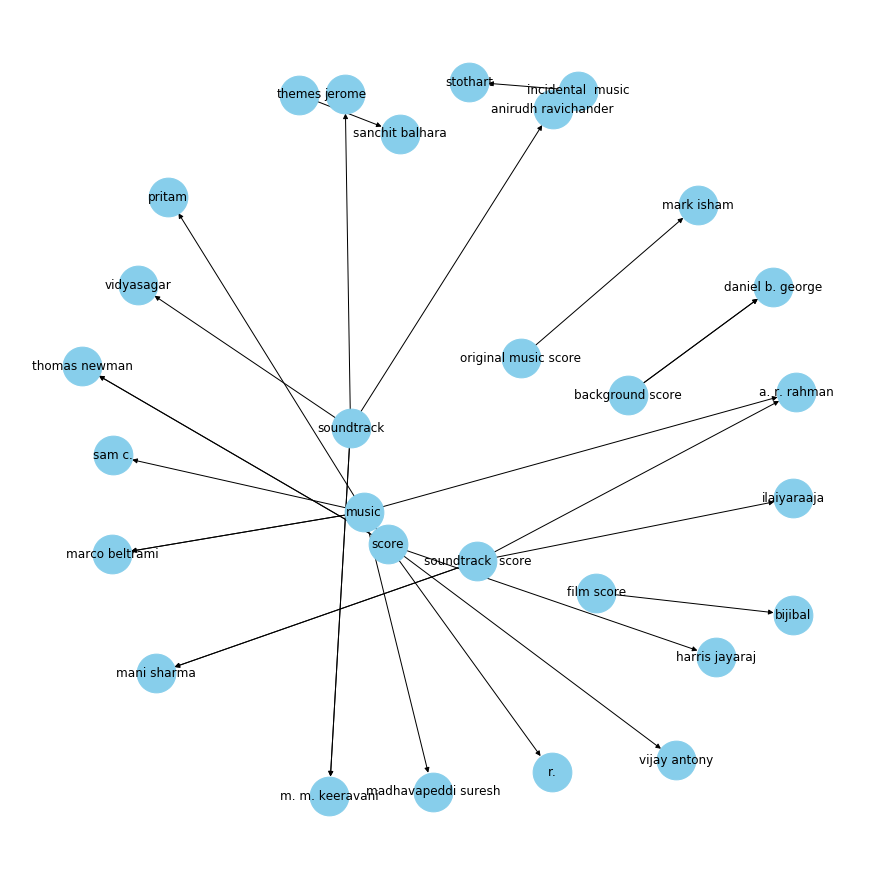

In [115]:
# visualisng relations with “composed by”:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

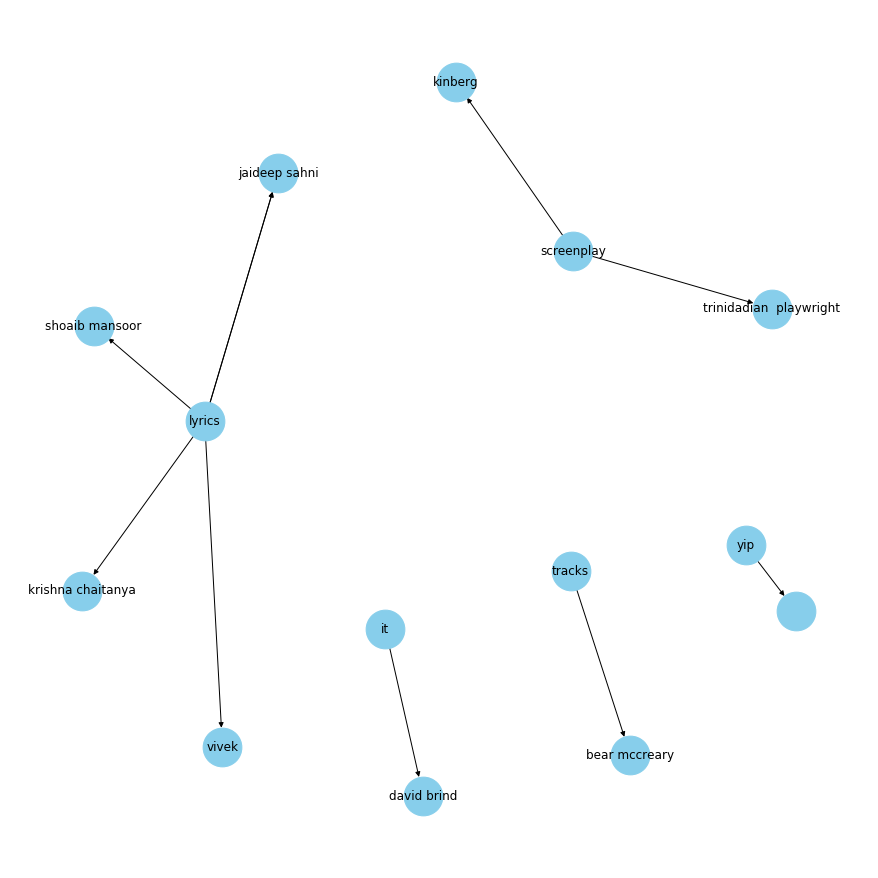

In [116]:
# visualisng relations with “written by”:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()